# Learning

In [2]:
#libs
import os
import re
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import glob
import math

In [3]:
# LAB
def find_txt_files(folder_path, session_numbers=None, exclude_folders=None):
    # Initialize the exclude_folders list if it wasn't provided
    if exclude_folders is None:
        exclude_folders = [
            r'L:\everyone\sharedDATA\RawDATA\3C280\3C280_S08_NoRec',
            r'L:\everyone\sharedDATA\RawDATA\3C280\Rubbish'
        ]
    
    # This list will store the paths of .txt files that match the session criteria
    txt_files_paths = []
    
    # Convert session numbers to a set of formatted strings for easier matching
    if session_numbers is not None:
        session_identifiers = {f'_S{num}_' for num in session_numbers}
    else:
        session_identifiers = None

    # Get all items in the root folder
    for item in os.listdir(folder_path):
        item_path = os.path.join(folder_path, item)
        
        # Check if this item is a directory and not in the exclude list
        if os.path.isdir(item_path) and item_path not in exclude_folders:
            # Search for .txt files in the directory
            for file in glob.glob(os.path.join(item_path, '*.txt')):
                if session_identifiers:
                    # Only add the file if its name contains one of the session identifiers
                    if any(session_id in os.path.basename(file) for session_id in session_identifiers):
                        txt_files_paths.append(file)
                else:
                    # If no session numbers are specified, add all .txt files
                    txt_files_paths.append(file)
        elif item_path.endswith('.txt'):
            # Also check .txt files in the root directory if session_identifiers is not specified
            # or if the file name contains one of the session identifiers
            if not session_identifiers or any(session_id in item for session_id in session_identifiers):
                txt_files_paths.append(item_path)

    return txt_files_paths

In [4]:
dir3C280 = r"L:\everyone\sharedDATA\RawDATA\3C280"
txt_path_list_3C280_old = find_txt_files(dir3C280, session_numbers = list(range(28, 34))) # sessions 28-33
txt_path_list_3C280_new = find_txt_files(dir3C280, session_numbers = [34,35,36,38]) # sessions 34,35,36,38

In [5]:
def performance_matrix(txt_files_paths):
    performance_list_all = [] 
    
    for path in txt_files_paths:
        s_x=[] # 1) ses_nb, 2) block_nb, 3) alpha rew, 4) beta rew, 5) with correction?, 6) before slash all 7) after slash all
        before_slash_list = []
        after_slash_list = []

        match = re.search(r'_S(\d+)_', path)
        s_x.append(int(match.group(1))) # ses_nb
        s_x.append(np.nan) # block_nb - dint figure out

        with open(path, 'r') as file:
            try:
                for line in file:
                    if "Protocol for session" in line:
                        # Extract protocol information using regular expressions
                        match = re.search(r'Alpha Trial = (\d+), Beta Trial = (\d+), correction implemented = (\d+)', line)
                        if match:
                            s_x.append(int(match.group(1))) #alpha_rew
                            s_x.append(int(match.group(2))) #beta_rew
                            s_x.append(int(match.group(3))) #corr
                    elif "Fraction correct trials" in line:
                        fraction_part = line.split('=')[-1].strip()
                        before_slash, after_slash = map(int, fraction_part.split('/'))
                        before_slash_list.append(before_slash)
                        after_slash_list.append(after_slash)
            except:
                continue

        s_x.append(before_slash_list)
        s_x.append(after_slash_list)

        performance_list_all.append(s_x)

        # now we will set a block number assuming that it is aquired as session x: 1,2,3,4 blocks
        for i in range(4):
            for s_x in performance_list_all[i::4]:
                s_x[1] = i+1
      
    
    return performance_list_all

In [6]:
performance_list_all_old = performance_matrix(txt_path_list_3C280_old)
performance_list_all_new = performance_matrix(txt_path_list_3C280_new)

In [7]:
performance_list_all_old[0]

[28,
 1,
 0,
 1,
 0,
 [1,
  1,
  2,
  2,
  3,
  3,
  3,
  4,
  5,
  5,
  5,
  5,
  5,
  6,
  6,
  6,
  6,
  6,
  7,
  8,
  8,
  8,
  8,
  8,
  9,
  9,
  9,
  9,
  9,
  9],
 [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30]]

## Learning across sessions

In [8]:
alpha_performance_30 = []
alpha_performance_20 = []

beta_performance_30 = []
beta_performance_20 = []

for block in performance_list_all_old:
    if block[2]==1: # alpha trial
        if block[6][-1]==30:
            alpha_performance_30.append(block[5][-1]/30)
        else:
            alpha_performance_20.append(block[5][-1]/20)
    else:
        if block[6][-1]==30:
            beta_performance_30.append(block[5][-1]/30)
        else:
            beta_performance_20.append(block[5][-1]/20)

In [31]:
def performance_bw_sessions(alpha_performance, beta_performance):
    plt.figure(figsize=(2.8,2.))
    plt.plot(alpha_performance, label='Performance with alpha mouse', color='#1F77B4', alpha=0.8, linewidth=2)
    plt.plot(beta_performance, label='Performance with beta mouse', color='#FF8113', alpha=0.8, linewidth=2)
    plt.axhline(0.5, color='black', linestyle='--', alpha=0.4)
    plt.ylabel('Fraction of correct',  fontsize=12)
    plt.xlabel('Session',  fontsize=12)
    plt.ylim(0,1)
    plt.xticks(range(len(alpha_performance)), labels=np.arange(1, (len(alpha_performance) + 1)))
    plt.yticks([0,0.5,1], labels=[0.0,0.5,1.0])
    # plt.legend()
    # plt.title(f'Nosepoke performance of {rec} mouse with pair {pair}\ntrials nb = {trials_nb}')
    plt.tight_layout()
    plt.savefig(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\models_behav_control\\performance over time.png', dpi=300, bbox_inches='tight')
    plt.show()

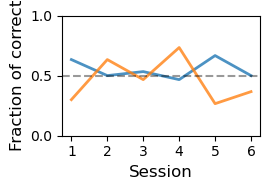

In [32]:
performance_bw_sessions(alpha_performance_30, beta_performance_30)

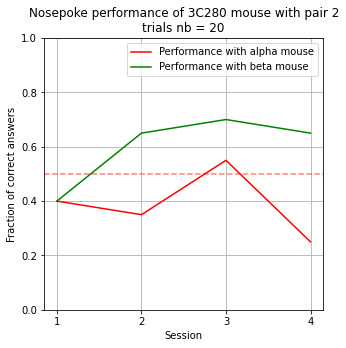

In [92]:
performance_bw_sessions(alpha_performance_20, beta_performance_20, trials_nb=20, pair=2)

## Learning within sesions - aka insite

In [94]:
alpha_performance_30 = []
alpha_performance_20 = []

beta_performance_30 = []
beta_performance_20 = []

for block in performance_list_all_new: # old - pair1; new - pair 2
    if block[2]==1: # alpha trial
        if block[6][-1]==30:
            first_half = block[5][-15]/15
            second_half = (-block[5][-15]+block[5][-1])/15
            alpha_performance_30.append([first_half, second_half])
        else:
            first_half = block[5][-10]/10
            second_half = (-block[5][-10]+block[5][-1])/10
            alpha_performance_20.append([first_half, second_half])
    else:
        if block[6][-1]==30:
            first_half = block[5][-15]/15
            second_half = (-block[5][-15]+block[5][-1])/15
            beta_performance_30.append([first_half, second_half])
        else:
            first_half = block[5][-10]/10
            second_half = (-block[5][-10]+block[5][-1])/10
            beta_performance_20.append([first_half, second_half])

In [95]:
alpha_performance_30 # first half, second half

[[0.9333333333333333, 0.4],
 [0.4666666666666667, 0.5333333333333333],
 [0.8, 0.6],
 [0.8666666666666667, 0.26666666666666666]]

In [96]:
def data_points_organisation(alpha_performance, beta_performance): #choose 30 or 20 trials
    performances = []

    first_half = np.zeros([len(alpha_performance),2])
    first_half[:,0] = np.array(alpha_performance)[:,0]
    first_half[:,1] = np.array(beta_performance)[:,0]
    performances.append(first_half)

    second_half = np.zeros([len(alpha_performance),2])
    second_half[:,0] = np.array(alpha_performance)[:,1]
    second_half[:,1] = np.array(beta_performance)[:,1]
    performances.append(second_half)
    
    performances = np.array(performances)

    # Mean values for each category in each block
    performances_means = []
    for half in performances:
        performances_means.append(np.mean(half, axis=0).tolist())
    performances_means = np.array(performances_means)

    performances_se = []
    for half in performances:
        performances_se.append((np.std(half, axis=0)/np.sqrt(len(half))).tolist())
    performances_se = np.array(performances_se)


    return performances, performances_means, performances_se

In [97]:
performances_30, performances_means_30, performances_se_30 = data_points_organisation(alpha_performance_30, beta_performance_30)
performances_20, performances_means_20, performances_se_20 = data_points_organisation(alpha_performance_20, beta_performance_20)

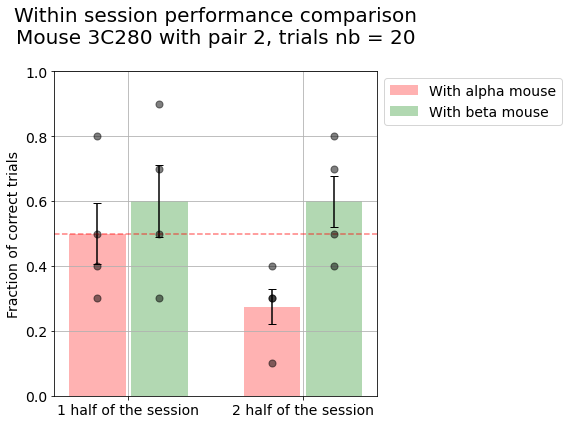

In [100]:
blocks, blocks_means, blocks_se = data_points_organisation(alpha_performance_20, beta_performance_20)
pair = 2
trials_nb = 20
mouse = '3C280'

n_groups = 2  # Number of groups (Blocks)
n_bars = 2  # Number of bars in each group

# Bar setup
bar_width = 0.2
gap_between_groups = 0.2
gap_between_bars = 0.02

group_width = n_bars * bar_width + (n_bars - 1) * gap_between_bars
start_pos = np.arange(n_groups) * (group_width + gap_between_groups)

fig, ax = plt.subplots(figsize=(8, 6))
colors = ['red', 'green']
labels = ['With alpha mouse', 'With beta mouse']

for i in range(n_bars):
    bar_positions = start_pos + i * (bar_width + gap_between_bars)
    ax.bar(bar_positions, blocks_means[:, i], width=bar_width, yerr=blocks_se[:, i], capsize=4, color=colors[i], alpha=0.3, label=labels[i])

    # Plotting individual points directly on bar positions
    for j in range(n_groups):
        individual_pos = np.array([bar_positions[j]] * len(blocks[j, :, i]))  # This ensures direct alignment with the bars
        ax.scatter(individual_pos, blocks[j, :, i], color='k', s=50, zorder=3, alpha=0.5)
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.5)
plt.xticks(start_pos + group_width / 2 - bar_width / 2, [f'{i+1} half of the session' for i in range(n_groups)], fontsize=14)
ax.set_ylabel('Fraction of correct trials', fontsize=14)
plt.yticks(fontsize=14)
ax.set_title(f'Within session performance comparison\nMouse {mouse} with pair {pair}, trials nb = {trials_nb}\n', fontsize=20)

ax.legend(loc='upper left', bbox_to_anchor=(1, 1),  fontsize=14)

plt.grid(True)
plt.ylim(0,1)
plt.tight_layout()
plt.show()

### Trials answers

In [33]:
def learning(correct_trials_array):
    x0 = 0
    array01 = []
    for i in range(len(correct_trials_array)):
        array01.append(correct_trials_array[i]-x0)
        x0 = correct_trials_array[i]
    array01 = np.array(array01)
    return array01

In [36]:
alpha_arrays01_30 = []
alpha_arrays01_20 = []

beta_arrays01_30 = []
beta_arrays01_20 = []

pair=2

for block in performance_list_all_old: # old/ new
    if block[2]==1: # alpha trial
        if block[6][-1]==30:
            alpha_arrays01_30.append(learning(block[5]))
        else:
            alpha_arrays01_20.append(learning(block[5]))
    else:
        if block[6][-1]==30:
            beta_arrays01_30.append(learning(block[5]))
        else:
            beta_arrays01_20.append(learning(block[5]))

In [68]:
def learning_plot(arrays, rec='3C280', stim='alpha', plot_size=(15, 3), colorbar_shrink=0.8, pair=pair):
    # Find the maximum length of the arrays
    max_len = max(len(arr) for arr in arrays)

    # Pad arrays with -1 to standardize their lengths
    standardized_arrays = np.array([np.pad(arr, (0, max_len - len(arr)), 'constant', constant_values=-1) for arr in arrays])

    # Define faded colors for red and green
    if stim == 'alpha':
        correct = '#84B4D6'
    else:
        correct = '#FFAA5F'
    wrong = '#7B7B7B'
    

    # Create custom colormap with faded colors
    cmap = plt.matplotlib.colors.ListedColormap([wrong, correct])

    # Create the heatmap
    plt.figure(figsize=plot_size)  # Adjust plot size here
    plt.imshow(standardized_arrays, aspect='auto', cmap=cmap, interpolation='nearest')

    # Create a colorbar with a tick for each integer value
    cbar = plt.colorbar(ticks=[0, 1], shrink=colorbar_shrink)
    cbar.ax.set_yticklabels(['0', '1'])

    # plt.title(f'{rec} mouse response to {stim} mouse (pair {pair})', fontsize=20)
    plt.xlabel('Trial', fontsize=12)
    plt.ylabel('Session', fontsize=12)
    plt.xticks([0,14,29], labels=[1,15,30])
    plt.yticks([0,5],labels=[1,6])
    plt.grid(False)  # Hide the grid for a cleaner visualization
    plt.tight_layout()
    plt.savefig(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\models_behav_control\\performance by trials - {stim}.png', dpi=300, bbox_inches='tight')
    plt.show()

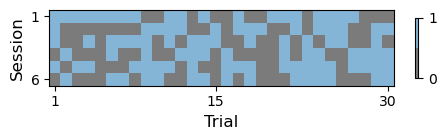

In [76]:
learning_plot(alpha_arrays01_30, plot_size=(5,1.5))

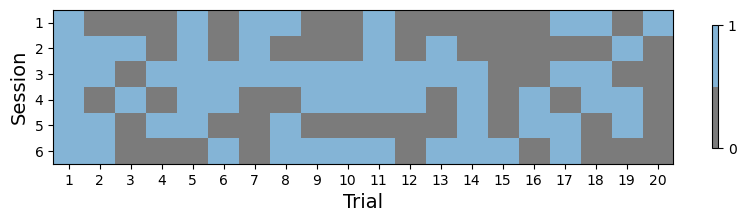

In [55]:
learning_plot(alpha_arrays01_20, plot_size=(10, 2))

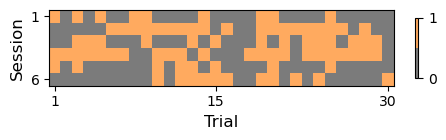

In [77]:
learning_plot(beta_arrays01_30, rec='3C280', stim='beta', plot_size=(5,1.5), colorbar_shrink=0.8)

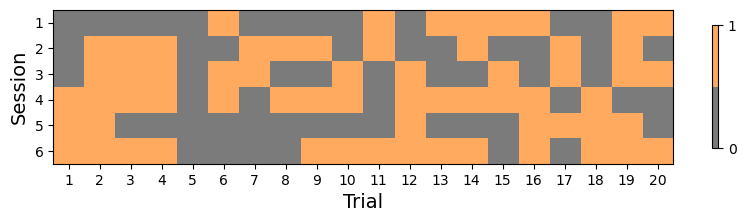

In [57]:
learning_plot(beta_arrays01_20, rec='3C280', stim='beta', plot_size=(10, 2), colorbar_shrink=0.8)

### Collapse

In [78]:
alpha_arrays01_30 = np.array(alpha_arrays01_30)
alpha_arrays01_20 = np.array(alpha_arrays01_20)

beta_arrays01_30 = np.array(beta_arrays01_30)
beta_arrays01_20 = np.array(beta_arrays01_20)

In [91]:
def collapsed_plot(matrix, rec='3C280', stim='alpha', plot_size=(15, 3)):
    if stim == 'alpha':
        color = '#84B4D6'
    else:
        color = '#FFAA5F'
    column_means = np.mean(matrix, axis=0)

    plt.figure(figsize=plot_size) 
    plt.axhline(0.5 ,color='black', linestyle='--', alpha=0.4)
    plt.plot(column_means, label='Mean performance', color=color, linewidth=2)
    
    plt.ylabel('Fraction of\ncorrect',  fontsize=12)
    plt.ylim(-0.01, 1.01)
    plt.xlim(0, 29)
    plt.xlabel('Trial', fontsize=12)
    plt.ylabel('Session', fontsize=12)
    plt.xticks([0,14,29], labels=[1,15,30])
    plt.yticks([0,0.5,1],labels=[0.0,0.5,1.0])
    plt.tight_layout()
    plt.savefig(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\models_behav_control\\performance by trials collapsed - {stim}.png', dpi=300, bbox_inches='tight')
    plt.show()


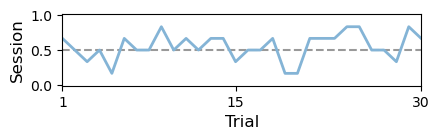

In [92]:
collapsed_plot(alpha_arrays01_30, rec='3C280', stim='alpha', plot_size=(4.5,1.5))

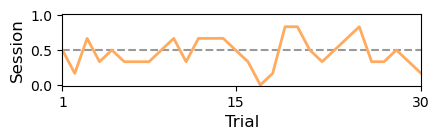

In [93]:
collapsed_plot(beta_arrays01_30, rec='3C280', stim='beta', plot_size=(4.5,1.5))

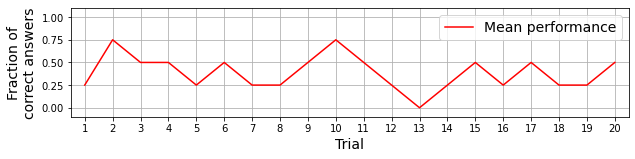

In [184]:
collapsed_plot(alpha_arrays01_20, rec='3C280', stim='alpha', plot_size=(10, 2))

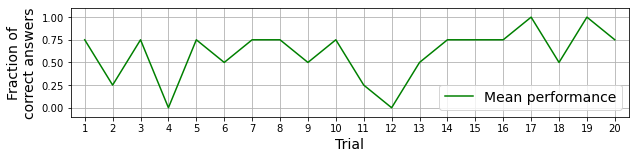

In [185]:
collapsed_plot(beta_arrays01_20, rec='3C280', stim='beta', plot_size=(10, 2))